In [1]:
%load_ext lab_black
%load_ext watermark
%matplotlib inline

import arviz as az

# import camelot
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import scipy as sp
import seaborn as sns
import theano
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler

warnings.simplefilter(action="ignore", category=FutureWarning)
az.style.use("arviz-darkgrid")
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]

In [2]:
def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def mean_by_cluster(param: str, post_df: pd.DataFrame):
    """
    Compute posterior mean of param by cluster (arrondissement) and category (parties)
    param: parameter to aggregate by cluster. Either "a_district_f" for parameter scale, or "p_district" for outcome scale
    post_df: posterior distribution of model, as a pd.DataFrame
    """
    mean_df = pd.DataFrame(index=range(Nparties), columns=range(Ndistricts))
    mean_df.index.name = "Party"
    mean_df.columns.name = "Arrondissement"

    for i in range(Ndistricts):
        mean_df[i] = (
            post_df[
                [
                    f"{param}__{i}_0",
                    f"{param}__{i}_1",
                    f"{param}__{i}_2",
                    f"{param}__{i}_3",
                    f"{param}__{i}_4",
                    f"{param}__{i}_5",
                    f"{param}__{i}_6",
                ]
            ]
            .mean()
            .values
        )

    return mean_df.T


def plot_compare_true(
    party_id: int, true_means: np.ndarray, mean_clusters_varying: pd.DataFrame
):
    """
    Compare true proportions and varying-effects estimates.
    If estimates are close to true proportions, it means this model
    looks appropriate
    party_id: from 0 to 6, as there are 7 parties
    """
    plt.figure(figsize=(11, 5))

    plt.plot(
        np.arange(Ndistricts),
        pd.DataFrame(true_means)[party_id],
        "o",
        ms=6,
        alpha=0.8,
        label="True proportions",
    )
    plt.plot(
        np.arange(Ndistricts),
        mean_clusters_varying[party_id],
        "o",
        fillstyle="none",
        ms=8,
        markeredgewidth=1.5,
        alpha=0.8,
        label="Varying-effects estimates",
    )

    plt.xticks(range(Ndistricts), range(1, Ndistricts + 1))
    plt.xlabel("Arrondissement")
    plt.ylabel(f"Share party {party_id} ({PARTIES[party_id]})")
    plt.legend(ncol=2, frameon=True, framealpha=0.5)

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [3]:
d = pd.read_excel("data/results_by_arrdmt.xlsx", index_col=0)
d = d[d.date != "2017-04-23"].reset_index(drop=True)
# A party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)
d.tail()

,date,ville,arrondissement,N,farleft,left,green,center,right,farright,other,type
135,2012-06-10,Paris,20,62422,9055,21881,11676,1800,10472,3940,3598,legislative
136,2014-03-25,Paris,20,54966,5692,20502,5990,0,11467,4112,7203,municipale
137,2014-05-25,Paris,20,49075,4974,10575,9498,4218,5994,4584,9232,european
138,2015-12-06,Paris,20,49130,6100,18315,7348,0,8340,4977,4050,regional
139,2017-06-11,Paris,20,57413,11546,10700,7766,6505,4300,2446,14150,legislative


What's the proportion of zeros in the respective categories?

In [6]:
1 - d[PARTIES].astype(bool).mean(axis=0).round(2)

farleft     0.03
left        0.00
green       0.00
center      0.29
right       0.00
farright    0.00
other       0.04
dtype: float64

Note that zeros in the category "other" are real multinomial zeros, while zeros in farleft, green and center result from the absence of these categories in the multinomial - they were eliminated upstream from the multinomial trials and are therefore not real multinomial zeros. Also note that the zero-inflated categories are not "jointly-inflated" (green is not necessaricly 0 when center is, and vice-versa).

Now let's look at each category's distribution (we zoom-in to really see zero-inflations):

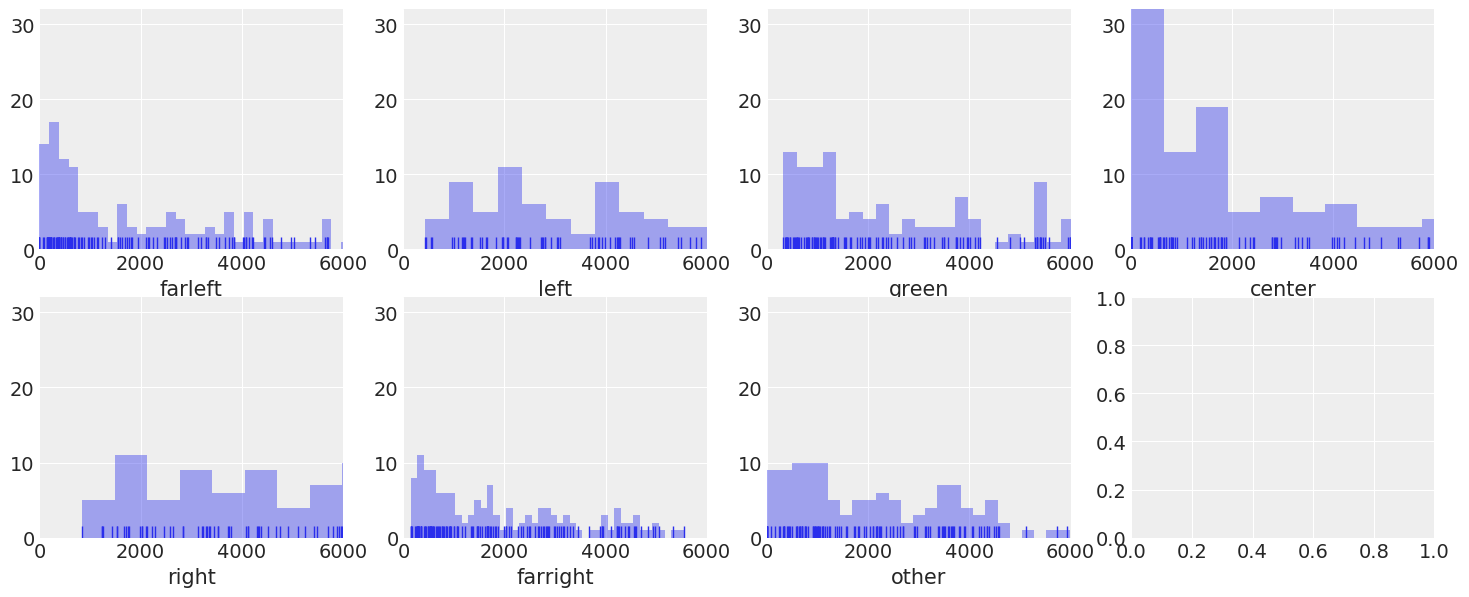

In [7]:
fig, axes = plt.subplots(2, 4, figsize=(18, 7))
i = 0
for line in axes:
    for col in line:
        try:
            sns.distplot(d[PARTIES[i]], bins=60, kde=False, rug=True, ax=col)
            col.set_xlim([0, 6_000])
            col.set_ylim([0, 32])
            i += 1
        except IndexError:
            continue

That's not the best plot, but we can see that farleft, green and center do have a tendency to zero-inflation. The zero inflation comes from the fact that sometimes, some parties don't compete in a given election. Here, this process is simulated exactly like it happened in reality for the four elections in our dataset - thanks to the variable `parties_available`. So, during the four elections, some parties are not available in all or some districts. Now, how can we model this mixed process?

First, let's define index variables:

In [4]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)
type_id, types = d.type.factorize(sort=True)
Ntypes = len(types)
date_id, dates = d.date.factorize(sort=True)
Ndates = len(dates)
Nparties = len(PARTIES)
N = d.N.values
R_obs = d[PARTIES].values  # for the real model

# which parties are available for choice ("other" always is):
parties_available = pd.concat(
    [
        d[PARTIES].astype(bool).astype(int).iloc[:, :-1],
        pd.Series([1] * len(d), name="other"),
    ],
    axis=1,
).values

Then we add a predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [5]:
unemp = pd.read_excel(
    "data/chomage-zone-demploi-2003-2019.xls", header=5, sheet_name="txcho_ze"
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]

# as timestamps variables:
unemp.index = pd.PeriodIndex(start=unemp.index[0], periods=len(unemp), freq="Q")
unemp

,unemployment
2003Q1,8.4
2003Q2,8.7
2003Q3,8.6
2003Q4,9.0
2004Q1,9.2
...,...
2018Q1,7.9
2018Q2,7.8
2018Q3,7.8
2018Q4,7.4


In [6]:
tables = camelot.read_pdf("data/real_estate_paris.pdf", pages="all", strip_text=" €")

prices = pd.concat(
    [tables[0].df.iloc[1:], tables[1].df.iloc[1:]], axis=0, ignore_index=True
)
prices.index = pd.PeriodIndex(start="2000Q4", periods=len(prices), freq="Q",)[::-1]
prices.index.name = "quarter"
prices.columns.name = "arrondissement"

prices = prices.drop(0, axis=1).sort_index().astype(float)
prices = prices.unstack()
prices.name = "prices"
prices

arrondissement  quarter
1               2000Q4     3500.0
                2001Q1     3780.0
                2001Q2     3930.0
                2001Q3     4150.0
                2001Q4     3940.0
                            ...  
20              2018Q2     7930.0
                2018Q3     8230.0
                2018Q4     8080.0
                2019Q1     8220.0
                2019Q2     8350.0
Name: prices, Length: 1500, dtype: float64

In [7]:
predictors = pd.read_json("../../../Desktop/predictors_daily.json")
predictors = predictors.loc[
    predictors.departement == "paris", ["date", "pib", "net_app"]
]
predictors.head()

,date,pib,net_app
685008,1992-01-31,0.546012,-16.67
685009,1992-02-01,0.546012,-16.67
685010,1992-02-02,0.546012,-16.67
685011,1992-02-03,0.546012,-16.67
685012,1992-02-04,0.546012,-16.67


In [6]:
preds = pd.read_csv(
    "data/predictors_by_district.csv", parse_dates=["year"], infer_datetime_format=True
)
preds["year"] = preds.year.dt.year
preds = preds.set_index(["arrondissement", "year"])
preds

actifs_occupes    big_house           cdd      chomeurs  \
arrondissement year                                                            
1              2006     9485.059228  1252.732849   1012.695824    895.724765   
               2007     9546.148694  1286.164264   1074.968469    922.094508   
               2008     9469.633224  1216.472899    993.190195    883.164655   
               2009     9665.691628  1302.325425    985.089081    915.091495   
               2010     9558.180760  1397.237101    959.031002    888.276570   
...                             ...          ...           ...           ...   
20             2015    90370.240523  3843.909770  10370.859531  16233.260643   
               2016    90874.227479  3948.492908  10335.255850  16037.251736   
               2017    90936.701645  3968.190376   9943.758332  16571.496502   
               2018    90917.272892  4025.603898   9732.150904  16859.038980   
               2019    90818.332088  4085.150428   9579.350096  17081.428057   

                     college_grad  csp_employed      csp_plus      empaid  \
arrondissement year                                                         
1              2006   7890.884720   1701.623443   4739.436591   29.045563   
               2007   8241.363122   1647.520281   4886.163367   41.166505   
               2008   8241.961872   1486.566750   5042.215106   32.648352   
               2009   8471.428572   1578.802223   5121.184955   15.404247   
               2010   8415.575368   1554.013248   5126.709956   13.047890   
...                           ...           ...           ...         ...   
20             2015  68786.240273  20587.795831  33664.134135  548.623173   
               2016  71851.173023  20514.362237  34691.926164  529.753550   
               2017  75777.953185  19995.235337  34330.223246  438.795993   
               2018  79002.319842  19482.271525  34691.789173  435.576125   
               2019  81505.795420  18895.056111  35366.612459  431.995141   

                         fam_mono   immigration     interim   min_diploma  \
arrondissement year                                                         
1              2006    482.374749   3148.134542   32.424709   2623.277344   
               2007    494.126055   3227.921219   24.481698   2475.048769   
               2008    473.505964   3121.358408   25.239743   2245.159195   
               2009    520.455533   3121.406343   31.114696   2248.727240   
               2010    509.405538   3021.113668   32.949848   2062.217398   
...                           ...           ...         ...           ...   
20             2015  10753.108869  41633.325845  994.985599  35383.166953   
               2016  10632.698061  41180.244725  964.492112  33556.709791   
               2017  10671.081485  40830.947452  870.453890  31784.431697   
               2018  10623.017339  40333.333716  819.132293  30058.031378   
               2019  10497.678014  39652.934880  770.275084  28370.444174   

                      non_college       pop2554       pop3044       pop4559  \
arrondissement year                                                           
1              2006   1897.393615   8849.957510   4707.453445   3416.928896   
               2007   1860.338159   8915.091416   4817.630783   3442.936791   
               2008   1834.442888   8845.308159   4818.893498   3220.943691   
               2009   1852.049112   8967.554268   4852.458184   3198.773394   
               2010   1922.670888   8886.736184   4792.879306   3134.694812   
...                           ...           ...           ...           ...   
20             2015  21547.794958  89863.300140  46207.513297  38751.485324   
               2016  20939.028457  90067.474203  46028.276939  38626.682454   
               2017  20455.461495  90336.126337  45397.609379  38770.757798   
               2018  20045.201405  90333.621964  44818.718005  39035.399471   
               2019  19728.0

In [7]:
# add quarters to original dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"
# merge with city-level unemployment:
d = d.join(unemp).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# join with district-level predictors:
d["year"] = d.date.dt.year
d = (
    d.set_index(["arrondissement", "year"])
    .join(preds)
    .reset_index()
    .drop("year", axis=1)
    .sort_values(["arrondissement", "date"])
)

# standartdize predictors:
unemp_ = stdz(np.log(d.unemployment)).values
d

,arrondissement,date,ville,N,farleft,left,green,center,right,farright,...,interim,min_diploma,non_college,pop2554,pop3044,pop4559,pop5579,pop6074,retired,youth
0,1,2008-05-23,Paris,6127,75,2289,439,531,2641,152,...,25.239743,2245.159195,1834.442888,8845.308159,4818.893498,3220.943691,3726.960725,2196.234294,434.413766,1816.180756
1,1,2010-03-14,Paris,4843,295,1077,1038,177,1758,261,...,32.949848,2062.217398,1922.670888,8886.736184,4792.879306,3134.694812,3600.179553,2092.698608,388.643955,1779.033595
2,1,2012-06-10,Paris,6256,219,2252,418,188,2577,297,...,49.079383,1941.165670,1999.964869,8609.767779,4446.740535,3199.653511,3654.870313,2182.941604,323.587919,1735.263159
3,1,2014-03-25,Paris,6079,154,1663,659,0,3144,306,...,45.729028,1874.550655,1875.560151,8090.922570,4152.774019,3231.746059,3869.012161,2421.806976,357.327042,1612.021135
4,1,2014-05-25,Paris,5430,186,956,623,753,1434,530,...,45.729028,1874.550655,1875.560151,8090.922570,4152.774019,3231.746059,3869.012161,2421.806976,357.327042,1612.021135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,20,2012-06-10,Paris,62422,9055,21881,11676,1800,10472,3940,...,1038.460995,39510.527039,22814.414012,91218.784981,48150.370414,38491.637337,41270.667858,24506.293474,6533.212180,18234.641207
136,20,2014-03-25,Paris,54966,5692,20502,5990,0,11467,4112,...,965.810470,37070.754157,21901.915225,90139.233180,46727.667351,38384.638482,42214.033848,25714.740471,5691.641883,18133.119561
137,20,2014-05-25,Paris,49075,4974,10575,9498,4218,5994,4584,...,965.810470,37070.754157,21901.915225,90139.233180,46727.667351,38384.638482,42214.033848,25714.740471,5691.641883,18133.119561
138,20,2015-12-06,Paris,49130,6100,18315,7348,0,8340,4977,...,994.985599,35383.166953,21547.794958,89863.300140,46207.513297,38751.485324,43037.092283,26419.511365,5153.572477,17977.773858


In [63]:
# disaggregate predictors for sklearn algorithm:
# X = d.loc[:, "unemployment":]
X = d[
    [
        "actifs_occupes",
        "big_house",
        "cdd",
        "chomeurs",
        "college_grad",
        "csp_plus",
        "empaid",
        "min_diploma",
        "non_college",
        "pop2554",
        "pop5579",
        "retired",
    ]
]
X = pd.DataFrame(
    data=StandardScaler().fit_transform(X), columns=X.columns, index=X.index,
)

X_train = pd.DataFrame(columns=X.columns)
for c in X.columns:
    X_train[c] = pd.Series([v] * s for v, s in zip(X[c], d["N"])).explode()
X_train = X_train.astype(float).values
X_train

array([[-1.31017502, -0.89788049, -1.22398459, ..., -1.28780809,
        -1.31574385, -1.1458908 ],
       [-1.31017502, -0.89788049, -1.22398459, ..., -1.28780809,
        -1.31574385, -1.1458908 ],
       [-1.31017502, -0.89788049, -1.22398459, ..., -1.28780809,
        -1.31574385, -1.1458908 ],
       ...,
       [ 1.13609063, -0.32733609,  1.25509778, ...,  1.22322542,
         1.27467267,  1.09788861],
       [ 1.13609063, -0.32733609,  1.25509778, ...,  1.22322542,
         1.27467267,  1.09788861],
       [ 1.13609063, -0.32733609,  1.25509778, ...,  1.22322542,
         1.27467267,  1.09788861]])

In [64]:
# disaggregate results for sklearn algorithm:
y_train = d.loc[:, "farleft":"other"].stack().reset_index()
y_train["level_1"] = [[p] * s for p, s in zip(y_train["level_1"], y_train[0])]
y_train = y_train["level_1"].explode().dropna().values  # NaNs are parties with 0 votes
y_train

array(['farleft', 'farleft', 'farleft', ..., 'other', 'other', 'other'],
      dtype=object)

In [65]:
X_train.shape, y_train.shape

((4643069, 12), (4643069,))

In [66]:
clf = LogisticRegression(
    C=0.01,
    multi_class="multinomial",
    penalty="l1",
    solver="saga",
    random_state=RANDOM_SEED,
    max_iter=500,
    n_jobs=-1,
    verbose=1,
)
clf.fit(X_train, y_train)

sparsity = np.mean(clf.coef_ == 0) * 100
# score = clf.score(X_test, y_test)
print(f"Sparsity with L1 penalty: {sparsity.round(2)}")
# print(f"Test score with L1 penalty: {score}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 14 epochs took 73 seconds
Sparsity with L1 penalty: 0.0


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


In [67]:
pd.DataFrame(data=clf.coef_, columns=X.columns, index=PARTIES).round(2)

,actifs_occupes,big_house,cdd,chomeurs,college_grad,csp_plus,empaid,min_diploma,non_college,pop2554,pop5579,retired
farleft,-2.82,-0.14,-2.87,-1.24,-0.80,-4.71,-0.80,-1.66,-8.29,17.98,3.77,1.56
left,2.54,-0.27,-0.00,0.67,0.11,-2.20,-0.45,-0.87,-2.26,2.92,0.00,0.52
green,0.74,-0.12,0.32,0.00,0.00,0.61,0.00,0.86,1.23,-1.38,0.00,-1.26
center,2.05,0.07,1.03,0.94,0.27,0.00,-0.20,0.00,-0.41,-1.77,-1.44,0.49
right,-0.76,0.00,0.57,-0.13,-0.71,1.46,0.38,0.56,0.46,-0.00,-0.64,-0.16
farright,0.00,0.07,-0.11,0.15,0.00,-2.13,0.05,-1.99,0.00,4.29,0.40,0.00
other,-0.32,0.01,-0.10,-0.27,3.35,0.62,0.23,2.58,0.37,-3.00,-2.04,-0.40


- farleft: `actifs_occupes`, `csp_plus`, `non_college`, `pop2554`, `pop5579`
- left: `actifs_occupes`, `csp_plus`, `non_college`, `pop2554`, `pop5579`
- green: `actifs_occupes`, `cdd`, `csp_plus`, `pop2554`
- center: `actifs_occupes`, `cdd`, `csp_plus`, `non_college`, `pop2554`, `pop5579`
- right: `actifs_occupes`, `csp_plus`, `non_college`, `pop2554`
- farright: `actifs_occupes`, `csp_plus`, `non_college`, `pop5579`

In [8]:
pred_matrix = {}
pred_matrix["farleft"] = stdz(
    np.log(d[["actifs_occupes", "csp_plus", "non_college", "pop2554", "pop5579"]])
).values
pred_matrix["left"] = stdz(
    np.log(d[["actifs_occupes", "csp_plus", "non_college", "pop2554", "pop5579"]])
).values
pred_matrix["green"] = stdz(np.log(d[["actifs_occupes", "csp_plus", "pop2554"]])).values
pred_matrix["center"] = stdz(
    np.log(d[["actifs_occupes", "csp_plus", "non_college", "pop2554", "pop5579"]])
).values
pred_matrix["right"] = stdz(
    np.log(d[["actifs_occupes", "csp_plus", "non_college", "pop2554"]])
).values
pred_matrix["farright"] = stdz(
    np.log(d[["actifs_occupes", "csp_plus", "non_college", "pop5579"]])
).values

In [9]:
with pm.Model() as m_simple:
    mus_parties = []

    for p_id, p in enumerate(PARTIES[:-1]):
        X = pred_matrix[p]

        a = pm.Normal(f"a_p{p_id}", -1.8, 1.0)
        b = pm.Normal(f"b_p{p_id}", 0.0, 0.5, shape=X.shape[1])
        sigma_a = pm.Exponential(f"sigma_a_p{p_id}", 1.0)

        za_district = pm.Normal(f"za_district_p{p_id}", 0.0, 1.0, shape=Ndistricts)

        A = a + sigma_a * za_district[district_id]
        mu = A + tt.dot(X, b)
        mus_parties.append(mu)
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 7 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_simple = pm.sample(
        1000,
        tune=6000,
        chains=2,
        cores=6,
        random_seed=RANDOM_SEED,
        init="adapt_diag",
        nuts_kwargs=dict(target_accept=0.9),
    )
# RUN NON HIERARCHICAL + SEE WHICH DISTRICT MAKES POO

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [za_district_p5, sigma_a_p5, b_p5, a_p5, za_district_p4, sigma_a_p4, b_p4, a_p4, za_district_p3, sigma_a_p3, b_p3, a_p3, za_district_p2, sigma_a_p2, b_p2, a_p2, za_district_p1, sigma_a_p1, b_p1, a_p1, za_district_p0, sigma_a_p0, b_p0, a_p0]
Sampling 2 chains, 0 divergences: 100%|██████████| 14000/14000 [38:24<00:00,  6.07draws/s]  
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [9]:
with pm.Model() as m_simple:
    mus_parties = []

    for p_id, p in enumerate(PARTIES[:-1]):
        X = pred_matrix[p].T

        a = pm.Normal(f"a_p{p_id}", -1.8, 1.0)
        b = pm.Normal(f"b_p{p_id}", 0.0, 0.5, shape=X.shape[0])
        sigma_a = pm.Exponential(f"sigma_a_p{p_id}", 1.0)
        sigma_b = pm.Exponential(f"sigma_b_p{p_id}", 1.0, shape=X.shape[0])

        za_district = pm.Normal(f"za_district_p{p_id}", 0.0, 1.0, shape=Ndistricts)
        zb_district = pm.Normal(
            f"zb_district_p{p_id}", 0.0, 1.0, shape=(Ndistricts, X.shape[0])
        )

        # mu = a_district[district_id] + tt.diag(tt.dot(b_district[district_id], X))
        A = a + sigma_a * za_district[district_id]
        distirct_slopes = tt.as_tensor_variable(
            [sigma_b[i] * zb_district[district_id, i] * X[i] for i in range(X.shape[0])]
        )
        B = b[:, None] + distirct_slopes
        mus_parties.append(A + tt.sum(B, axis=0))
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 7 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_simple = pm.sample(
        1000,
        tune=6000,
        chains=2,
        cores=6,
        random_seed=RANDOM_SEED,
        init="adapt_diag",
        nuts_kwargs=dict(target_accept=0.9),
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [zb_district_p5, za_district_p5, sigma_b_p5, sigma_a_p5, b_p5, a_p5, zb_district_p4, za_district_p4, sigma_b_p4, sigma_a_p4, b_p4, a_p4, zb_district_p3, za_district_p3, sigma_b_p3, sigma_a_p3, b_p3, a_p3, zb_district_p2, za_district_p2, sigma_b_p2, sigma_a_p2, b_p2, a_p2, zb_district_p1, za_district_p1, sigma_b_p1, sigma_a_p1, b_p1, a_p1, zb_district_p0, za_district_p0, sigma_b_p0, sigma_a_p0, b_p0, a_p0]
Sampling 2 chains, 0 divergences: 100%|██████████| 14000/14000 [2:50:06<00:00,  1.37draws/s]  
The acceptance probability does not match the target. It is 0.9963835618418426, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat s

In [14]:
with open("trace_nocov.pkl", "wb") as f:
    pickle.dump({"model": m_simple, "trace": trace_simple}, f)

In [11]:
baselines = [
    "a_p0",
    "a_p1",
    "a_p2",
    "a_p3",
    "a_p4",
    "a_p5",
    "b_p0",
    "b_p1",
    "b_p2",
    "b_p3",
    "b_p4",
    "b_p5",
]
sigmas = [
    "sigma_a_p0",
    "sigma_a_p1",
    "sigma_a_p2",
    "sigma_a_p3",
    "sigma_a_p4",
    "sigma_a_p5",
    "sigma_b_p0",
    "sigma_b_p1",
    "sigma_b_p2",
    "sigma_b_p3",
    "sigma_b_p4",
    "sigma_b_p5",
]

In [15]:
az.summary(
    trace_simple, var_names=sigmas, round_to=2,
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma_a_p0,1.24,0.02,1.22,1.27,0.01,0.01,2.02,2.02,2.70,16.58,2.03
sigma_a_p1,15.56,1.93,13.63,17.60,1.36,1.15,2.02,2.02,2.29,13.64,2.90
sigma_a_p2,13.13,6.87,6.23,20.01,4.84,4.10,2.02,2.02,2.63,21.34,2.12
sigma_a_p3,64.77,8.72,56.04,73.49,6.14,5.20,2.02,2.02,2.56,14.41,2.23
sigma_a_p4,17.36,2.28,15.08,19.66,1.61,1.36,2.02,2.02,2.86,12.46,1.89
sigma_a_p5,1.01,0.13,0.87,1.22,0.08,0.07,2.49,2.46,3.69,10.93,2.12
sigma_b_p0[0],5.10,4.58,0.89,12.65,3.17,2.66,2.09,2.09,2.44,10.97,2.47
sigma_b_p0[1],1.16,0.06,1.10,1.23,0.05,0.04,2.02,2.02,2.68,22.24,2.11
sigma_b_p0[2],1.65,0.60,0.97,2.25,0.42,0.36,2.02,2.02,2.43,10.91,2.50
sigma_b_p0[3],4.82,4.05,0.77,8.87,2.85,2.41,2.02,2.02,2.29,12.53,2.96


`actifs`, `immigration` and `youth` don't seem to have much influence on the results. `log_college` is slightly higher but still inconclusive. 

`log_unemp` seems to be pretty associated with the results.

In [ ]:
# sondages, new clusters (type elec), non-linearity, measurement error on preds, city-level predictors, GP for dates

In [30]:
with pm.Model() as m_nocov:
    # a = pm.Normal("a", -1.8, 1.0, shape=Nparties - 1)
    # bC = pm.Normal("bC", 0.0, 0.5, shape=Nparties - 1)
    sigma_dis = pm.Exponential("sigma_dis", 1.0, shape=(2, Nparties - 1))
    sigma_date = pm.Exponential("sigma_date", 1.0, shape=(2, Nparties - 1))
    # sigma_bC = pm.Exponential("sigma_bC", 1.0, shape=Nparties - 1)

    # a_district = pm.Normal("a_district", a, sigma_a_dis, shape=(Ndistricts, Nparties - 1))
    # a_date = pm.Normal("a_date", 0., sigma_a_date, shape=(Ndates, Nparties - 1))
    # bC_district = pm.Normal("bC_district", bC, sigma_bC, shape=(Ndistricts, Nparties - 1))

    baseline_a = pm.Normal("baseline_a", -1.8, 1.0, shape=Nparties - 1)
    baseline_b = pm.Normal("baseline_b", 0.0, 0.5, shape=Nparties - 1)
    district_effect = pm.Normal(
        "district_effect", 0.0, sigma_dis, shape=(Ndistricts, 2, Nparties - 1)
    )
    date_effect = pm.Normal(
        "date_effect", 0.0, sigma_date, shape=(Ndates, 2, Nparties - 1)
    )

    # big_house = pm.Data("big_house", stdz(np.log(d.big_house)).values)
    # chomeurs = pm.Data("chomeurs", stdz(np.log(d.chomeurs)).values)
    unemp = pm.Data("umemp", stdz(np.log(d.unemployment)).values)

    # linear model:
    A = baseline_a + district_effect[district_id, 0] + date_effect[date_id, 0]
    BC = baseline_b + district_effect[district_id, 1] + date_effect[date_id, 1]
    mu = A + BC * unemp

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mu = tt.horizontal_stack(mu, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mu))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_nocov = pm.sample(
        1000, tune=4000, chains=2, cores=6, random_seed=RANDOM_SEED, init="adapt_diag"
    )

az.summary(
    trace_nocov,
    var_names=["baseline_a", "baseline_b", "sigma_dis", "sigma_date",],
    round_to=2,
)

(140, 7)


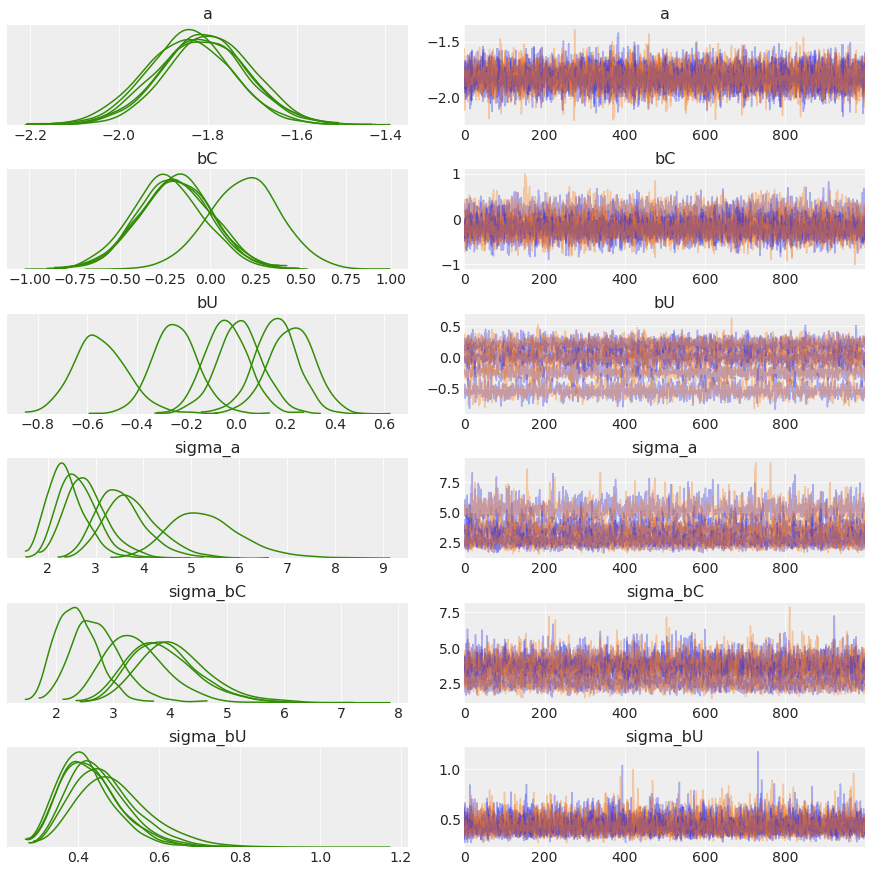

In [9]:
az.plot_trace(
    trace_nocov,
    var_names=["a", "bC", "bU", "sigma_a", "sigma_bC", "sigma_bU"],
    compact=True,
    combined=True,
)

In [40]:
# counterfactuals for a given district:
d_id = np.random.randint(0, Ndistricts)
predictor_seq = np.linspace(-3, 4)  # other predictor held at 0
mus_pp = []
for pred in predictor_seq:
    mus_pp.append(
        trace_nocov["a_district"][:, d_id, :]
        + trace_nocov["bC_district"][:, d_id, :] * pred
    )
mus_pp = np.asarray(mus_pp).transpose(2, 0, 1)

# append last category:
mus_other = np.full(shape=(1, mus_pp.shape[1], mus_pp.shape[2]), fill_value=-2.2)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of predictor, given other one held at 0:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000)

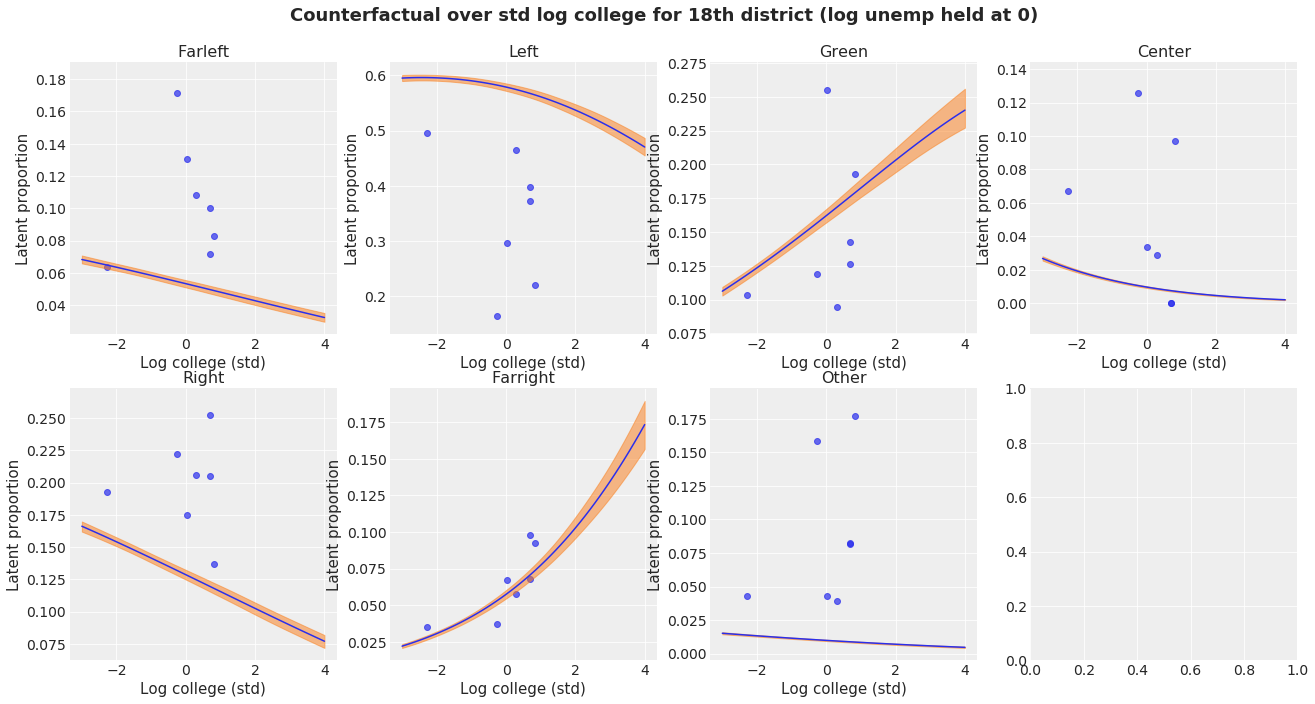

In [41]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            col.scatter(
                d.loc[d.arrondissement == d_id + 1, "log_college"],
                d.loc[d.arrondissement == d_id + 1, f"{PARTIES[i]}"]
                / d.loc[d.arrondissement == d_id + 1, "N"],
                alpha=0.7,
            )
            col.plot(predictor_seq, prob_mean[i, :])
            az.plot_hpd(predictor_seq, prob_pp[i, :, :].T, ax=col)
            col.set_xlabel("Log college (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Counterfactual over std log college for {d_id + 1}th district (log unemp held at 0)",
    y=0.95,
    size=18,
    weight="bold",
);

In [47]:
# counterfactuals for all districts:
mus_pp = []
for pred in predictor_seq:
    mus_pp.append(trace_nocov["a_district"] + trace_nocov["bC_district"] * pred)
mus_pp = np.asarray(mus_pp).transpose(3, 2, 0, 1)

# append last category:
mus_other = np.full(
    shape=(1, mus_pp.shape[1], mus_pp.shape[2], mus_pp.shape[3]), fill_value=-2.2
)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 20, 50, 2000)

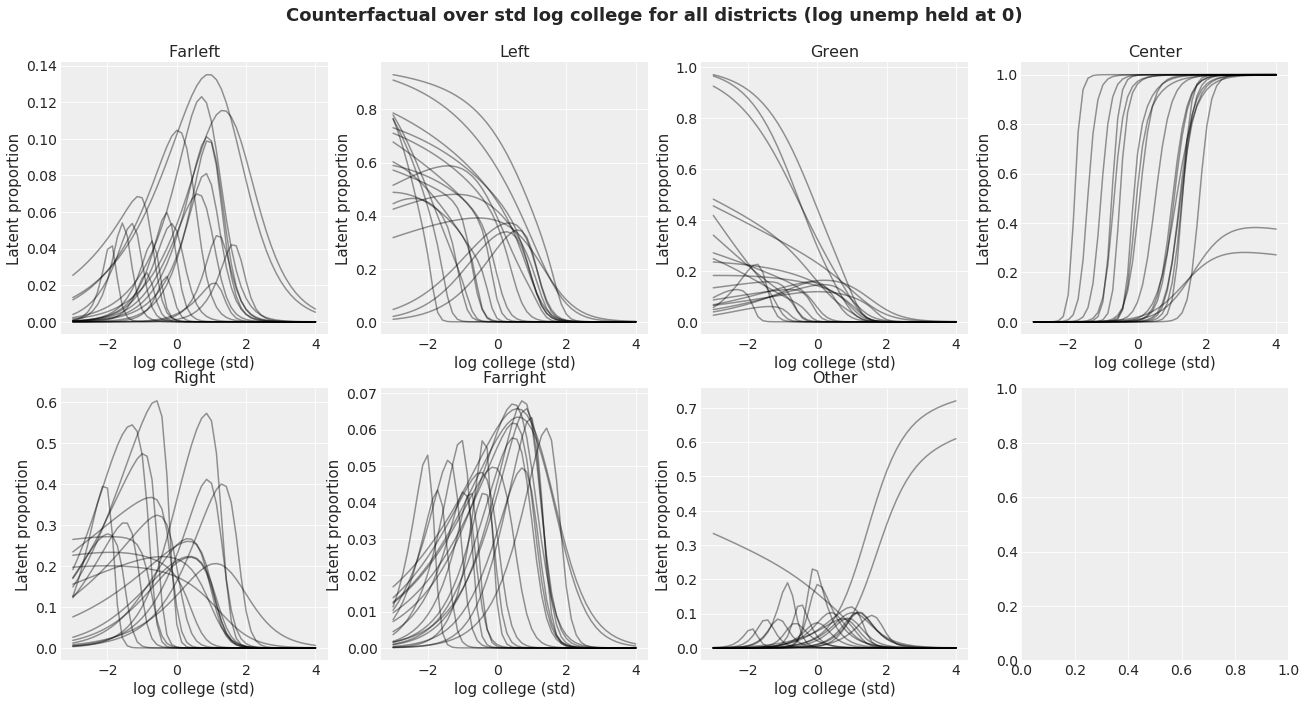

In [48]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(3)
i = 0
for line in axes:
    for col in line:
        try:
            for dis in range(Ndistricts):
                col.plot(predictor_seq, prob_mean[i, dis, :], "k", alpha=0.4)
            col.set_xlabel("log college (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    "Counterfactual over std log college for all districts (log unemp held at 0)",
    y=0.95,
    size=18,
    weight="bold",
)

In [56]:
share_est = trace_nocov["slot_prob"]
share_mean = share_est.mean(0)

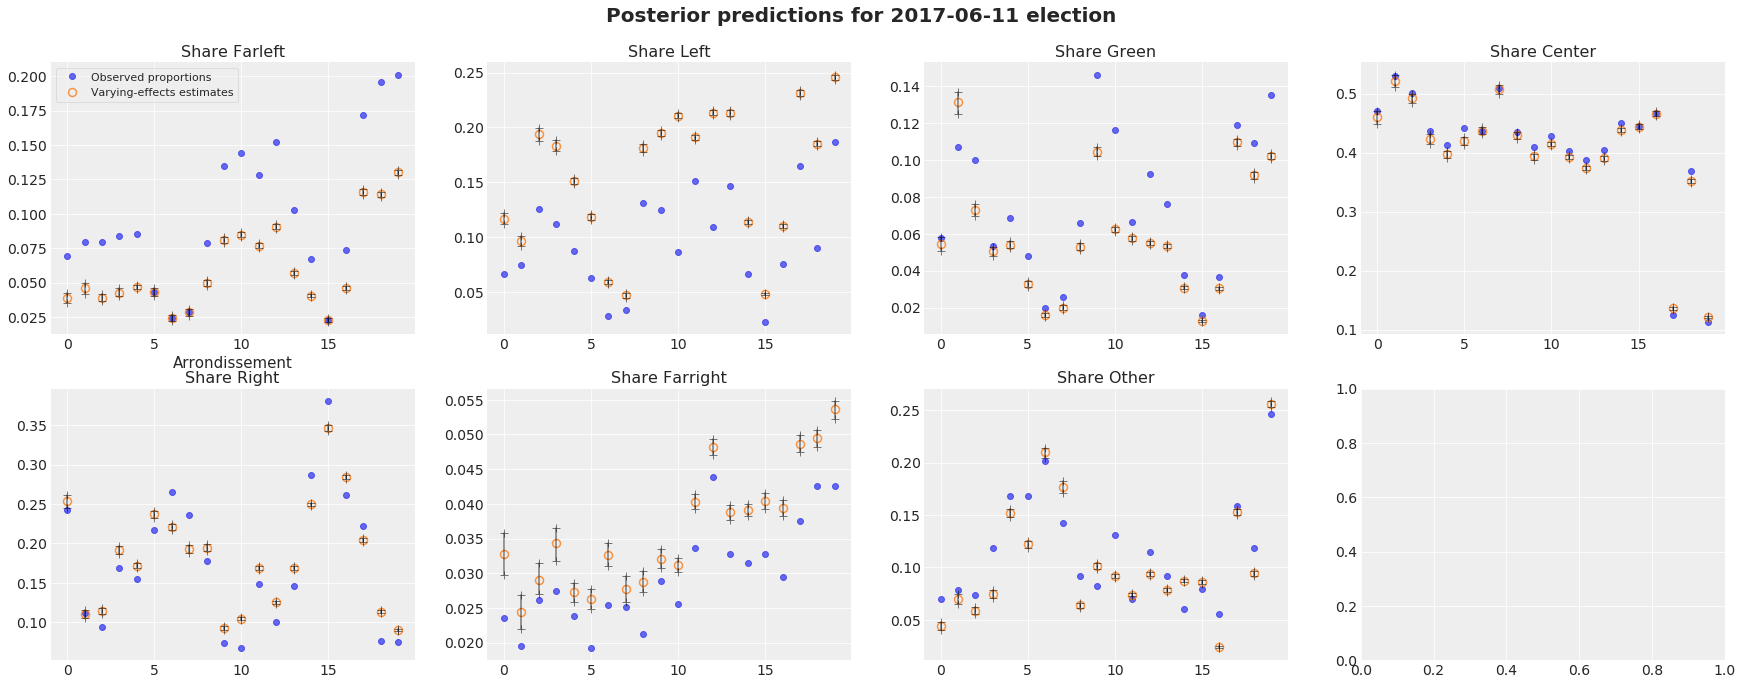

In [63]:
election = "2017-06-11"
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
i = 0
for line in axes:
    for col in line:
        try:
            col.plot(
                np.arange(Ndistricts),
                d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
                "o",
                ms=6,
                alpha=0.7,
                label="Observed proportions",
            )
            col.plot(
                np.arange(Ndistricts),
                share_mean[election_mask, i],
                "o",
                fillstyle="none",
                ms=8,
                markeredgewidth=1.5,
                alpha=0.8,
                label="Varying-effects estimates",
            )
            col.plot(
                [np.arange(Ndistricts), np.arange(Ndistricts)],
                az.hpd(share_est[:, election_mask, i]).T,
                "k-+",
                ms=8,
                alpha=0.5,
            )
            col.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
            col.set_title(f"Share {PARTIES[i].title()}")
            if i == 0:
                col.set_xlabel("Arrondissement")
                col.legend(frameon=True, framealpha=0.5, fontsize=11)
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Posterior predictions for {election} election", y=0.95, size=20, weight="bold",
)

In [8]:
# add quarters to original dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"

# merge with unemployment (same for whole city):
d = (
    d.join(pred)
    .sort_values(["arrondissement", "date"])
    .reset_index()
    .set_index(["arrondissement", "quarter"])
)

# merge with real estate prices (different for each district):
d = d.join(prices).reset_index().drop("quarter", axis=1)

# merge with other national predictors:
d = pd.merge(d, predictors, left_on="date", right_on="date")

# standardize predictors:
d["log_unemp"] = stdz(np.log(d["unemployment"].values))
d["prices_stdz"] = stdz(d["prices"])
d["log_prices"] = stdz(np.log(d["prices"].values))
d["log_pib"] = stdz(np.log(d["pib"].values))
d["net_app"] = stdz(d["net_app"])
d.tail()

,arrondissement,date,ville,N,farleft,left,green,center,right,farright,other,type,unemployment,prices,pib,net_app,log_unemp,prices_stdz,log_prices,log_pib
55,16,2017-06-11,Paris,51079,1161,1157,803,22759,19453,1675,4071,legislative,8.0,9320.0,0.844163,1.211832,0.286071,0.500409,0.577020,1.41306
56,17,2017-06-11,Paris,56199,4142,4227,2040,26291,14701,1655,3143,legislative,8.0,8820.0,0.844163,1.211832,0.286071,0.213587,0.310662,1.41306
57,18,2017-06-11,Paris,54371,9339,8969,6474,6828,12097,2039,8625,legislative,8.0,7770.0,0.844163,1.211832,0.286071,-0.388740,-0.301614,1.41306
58,19,2017-06-11,Paris,50024,9798,4488,5463,18429,3790,2129,5927,legislative,8.0,6940.0,0.844163,1.211832,0.286071,-0.864864,-0.847310,1.41306
59,20,2017-06-11,Paris,57413,11546,10700,7766,6505,4300,2446,14150,legislative,8.0,7200.0,0.844163,1.211832,0.286071,-0.715717,-0.669647,1.41306


Ok, everything's ready, let's run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions.

In [9]:
with pm.Model() as m_real:
    mus_parties = []
    log_unemp = pm.Data("log_unemp", d.log_unemp.values)
    log_pib = pm.Data("log_pib", d.log_pib.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_unemp
            + ab_district[district_id, 2] * log_pib
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

with open("trace_UG.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)


with pm.Model() as m_real:
    mus_parties = []
    log_unemp = pm.Data("log_unemp", d.log_unemp.values)
    net_app = pm.Data("net_app", d.net_app.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_unemp
            + ab_district[district_id, 2] * net_app
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

with open("trace_UA.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)


with pm.Model() as m_real:
    mus_parties = []
    log_pib = pm.Data("log_pib", d.log_pib.values)
    net_app = pm.Data("net_app", d.net_app.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_pib
            + ab_district[district_id, 2] * net_app
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

with open("trace_GA.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)


with pm.Model() as m_real:
    mus_parties = []
    log_pib = pm.Data("log_pib", d.log_pib.values)
    log_prices = pm.Data("log_prices", d.log_prices.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_pib
            + ab_district[district_id, 2] * log_prices
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

with open("trace_GP.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)


with pm.Model() as m_real:
    mus_parties = []
    net_app = pm.Data("net_app", d.net_app.values)
    log_prices = pm.Data("log_prices", d.log_prices.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * net_app
            + ab_district[district_id, 2] * log_prices
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

with open("trace_AP.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)


with pm.Model() as m_real:
    mus_parties = []
    log_unemp = pm.Data("log_unemp", d.log_unemp.values)
    log_prices = pm.Data("log_prices", d.log_prices.values)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=3, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=3, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}",
            mu=np.array([-1.8, 0.0, 0.0]),
            sd=np.array([0.1, 0.5, 0.5]),
            shape=3,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 3)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0]
            + ab_district[district_id, 1] * log_unemp
            + ab_district[district_id, 2] * log_prices
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=3000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag",
    )

with open("trace_UP.pkl", "wb") as f:
    pickle.dump({"model": m_real, "trace": trace_real}, f)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
Sampling 2 chains, 20 divergences: 100%|██████████| 8000/8000 [1:53:46<00:00,  1.17draws/s] 
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters

In [10]:
with pm.Model() as m_real:
    mus_parties = []
    # price = pm.Data("price", d.prices.values)
    unemployment = pm.Data("unemployment", unemp_)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation among districts):
        sd_dist = pm.Exponential.dist(1)
        packed_chol = pm.LKJCholeskyCov(f"chol_cov_p{p}", eta=4, n=2, sd_dist=sd_dist)

        # compute covariance matrix:
        chol = pm.expand_packed_triangular(n=2, packed=packed_chol, lower=True)
        cov = pm.math.dot(chol, chol.T)

        # extract rho and standard deviations:
        sigma_ab = pm.Deterministic(f"sigma_pop_p{p}", tt.sqrt(tt.diag(cov)))
        corr = tt.diag(sigma_ab ** -1).dot(cov.dot(tt.diag(sigma_ab ** -1)))
        r = pm.Deterministic(f"Rho_p{p}", corr[np.triu_indices(n=2, k=1)])

        # average itc and slopes for each party:
        ab = pm.Normal(
            f"ab_p{p}", mu=np.array([-1.8, 0.0]), sd=np.array([1.0, 0.5]), shape=2,
        )

        # population of varying effects:
        ab_district = pm.MvNormal(
            f"ab_district_p{p}", mu=ab, chol=chol, shape=(Ndistricts, 2)
        )
        # linear model:
        mus_parties.append(
            ab_district[district_id, 0] + ab_district[district_id, 1] * unemployment
        )
    mus_parties = tt.as_tensor_variable(mus_parties).T

    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(Ndistricts, 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot[district_id])

    # preferences of each district, for 4 elections:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000, tune=4000, cores=6, chains=2, random_seed=RANDOM_SEED, init="adapt_diag"
    )

# with open("trace_prices.pkl", "wb") as f:
#   pickle.dump({"model": m_real, "trace": trace_real}, f)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [ab_district_p5, ab_p5, chol_cov_p5, ab_district_p4, ab_p4, chol_cov_p4, ab_district_p3, ab_p3, chol_cov_p3, ab_district_p2, ab_p2, chol_cov_p2, ab_district_p1, ab_p1, chol_cov_p1, ab_district_p0, ab_p0, chol_cov_p0]
Sampling 2 chains, 0 divergences: 100%|██████████| 10000/10000 [10:05<00:00, 16.52draws/s]


In [49]:
with pm.Model() as m_real:
    mus_parties = []
    # chomeurs = pm.Data("chomeurs", stdz(np.log(d.chomeurs)).values)
    unemployment = pm.Data("unemployment", unemp_)

    for p in range(Nparties - 1):
        # prior stddev for itcs and slopes (i.e variation within clusters):
        sd_dist = pm.Exponential.dist(1.0)
        pchol1 = pm.LKJCholeskyCov(f"pchol_district_{p}", eta=4, n=2, sd_dist=sd_dist)
        pchol2 = pm.LKJCholeskyCov(f"pchol_date_{p}", eta=4, n=2, sd_dist=sd_dist)
        chol1 = pm.expand_packed_triangular(2, pchol1, lower=True)
        chol2 = pm.expand_packed_triangular(2, pchol2, lower=True)
        
        # compute covariance matrix:
        cov1 = pm.math.dot(chol1, chol1.T)
        cov2 = pm.math.dot(chol2, chol2.T)

        # extract rho and standard deviations:
        sigma_district = pm.Deterministic(f"sigma_district_{p}", tt.sqrt(tt.diag(cov1)))
        corr1 = tt.diag(sigma_district ** -1).dot(cov1.dot(tt.diag(sigma_district ** -1)))
        r1 = pm.Deterministic(f"Rho_district_{p}", corr1[np.triu_indices(n=2, k=1)])
        sigma_date = pm.Deterministic(f"sigma_date_{p}", tt.sqrt(tt.diag(cov2)))
        corr2 = tt.diag(sigma_date ** -1).dot(cov2.dot(tt.diag(sigma_date ** -1)))
        r2 = pm.Deterministic(f"Rho_date_{p}", corr2[np.triu_indices(n=2, k=1)])

        # average itc and slope:
        baseline_a = pm.Normal(f"baseline_a{p}", -1.8, 1.0)
        baseline_b = pm.Normal(f"baseline_b_{p}", 0.0, 0.5)

        # population of varying effects:
        b1 = pm.Normal(f"b1_{p}", 0.0, 1.0, shape=(2, Ndistricts))
        b2 = pm.Normal(f"b2_{p}", 0.0, 1.0, shape=(2, Ndates))
        district_effect = pm.Deterministic(
            f"district_effect_{p}", pm.math.dot(chol1, b1)
        )
        date_effect = pm.Deterministic(f"date_effect_{p}", pm.math.dot(chol2, b2))

        # linear model:
        A = baseline_a + district_effect[0, district_id] + date_effect[0, date_id]
        BU = baseline_b + district_effect[1, district_id] + date_effect[1, date_id]
        mus_parties.append(A + BU * unemployment)

    mus_parties = tt.as_tensor_variable(mus_parties).T
    # append last category:
    vary_pivot = tt.as_tensor_variable(np.full(shape=(len(d), 1), fill_value=-2.2))
    mus_parties = tt.horizontal_stack(mus_parties, vary_pivot)

    # preferences per district and date:
    lat_p = pm.Deterministic("lat_p", tt.nnet.softmax(mus_parties))

    # zero-inflation process:
    # keep only preferences for available parties:
    slot_prob = parties_available * lat_p
    # normalize preferences:
    slot_prob = pm.Deterministic(
        "slot_prob", slot_prob / tt.sum(slot_prob, axis=1, keepdims=True)
    )
    R = pm.Multinomial("R", n=N, p=slot_prob, observed=R_obs)

    trace_real = pm.sample(
        1000,
        tune=6000,
        cores=6,
        chains=2,
        random_seed=RANDOM_SEED,
        init="adapt_diag",
        nuts_kwargs={"target_accept": 0.95},
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 6 jobs)
NUTS: [b2_5, b1_5, baseline_b_5, baseline_a5, pchol_date_5, pchol_district_5, b2_4, b1_4, baseline_b_4, baseline_a4, pchol_date_4, pchol_district_4, b2_3, b1_3, baseline_b_3, baseline_a3, pchol_date_3, pchol_district_3, b2_2, b1_2, baseline_b_2, baseline_a2, pchol_date_2, pchol_district_2, b2_1, b1_1, baseline_b_1, baseline_a1, pchol_date_1, pchol_district_1, b2_0, b1_0, baseline_b_0, baseline_a0, pchol_date_0, pchol_district_0]
Sampling 2 chains, 20 divergences: 100%|██████████| 10000/10000 [2:30:54<00:00,  1.10draws/s]
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.886735278708876, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 4 dive

In [8]:
with open("trace_both.pkl", "rb") as f:
    data = pickle.load(f)
m_real, trace_real = data["model"], data["trace"]
post_real = pm.trace_to_dataframe(trace_real)

In [9]:
summ = az.summary(trace_real, round_to=2)
summ[summ.r_hat >= 1.05]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
chol_cov_p3[5],0.22,0.23,0.01,0.63,0.03,0.02,43.08,43.08,29.28,67.31,1.06
sigma_pop_p3[2],0.24,0.25,0.01,0.70,0.04,0.03,42.79,42.79,29.52,66.70,1.06


In [10]:
az.summary(
    trace_real,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    round_to=2,
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ab_p0[0],-1.78,0.09,-1.96,-1.61,0.00,0.00,3000.56,2884.23,3055.26,1135.15,1.00
ab_p0[1],-0.84,0.14,-1.10,-0.59,0.00,0.00,2573.10,2573.10,2681.55,1303.33,1.00
ab_p0[2],-0.08,0.28,-0.56,0.48,0.01,0.01,3089.02,1028.89,3109.47,1312.08,1.00
ab_p1[0],-1.79,0.10,-1.96,-1.60,0.00,0.00,4064.24,4064.24,3994.23,1207.72,1.00
ab_p1[1],0.43,0.20,0.04,0.79,0.00,0.00,2077.43,2004.13,2057.05,1756.46,1.00
ab_p1[2],-1.45,0.50,-2.41,-0.54,0.01,0.01,2331.88,2331.88,2370.55,1406.53,1.00
ab_p2[0],-1.81,0.10,-1.97,-1.62,0.00,0.00,3828.67,3703.28,3872.30,1121.15,1.00
ab_p2[1],-0.12,0.13,-0.36,0.13,0.00,0.00,2509.03,1365.67,2564.53,1401.51,1.00
ab_p2[2],-0.92,0.32,-1.53,-0.34,0.01,0.00,2494.87,2494.87,2563.67,1562.47,1.00
ab_p3[0],-1.68,0.10,-1.87,-1.50,0.00,0.00,3331.66,3292.15,3331.25,1351.11,1.00


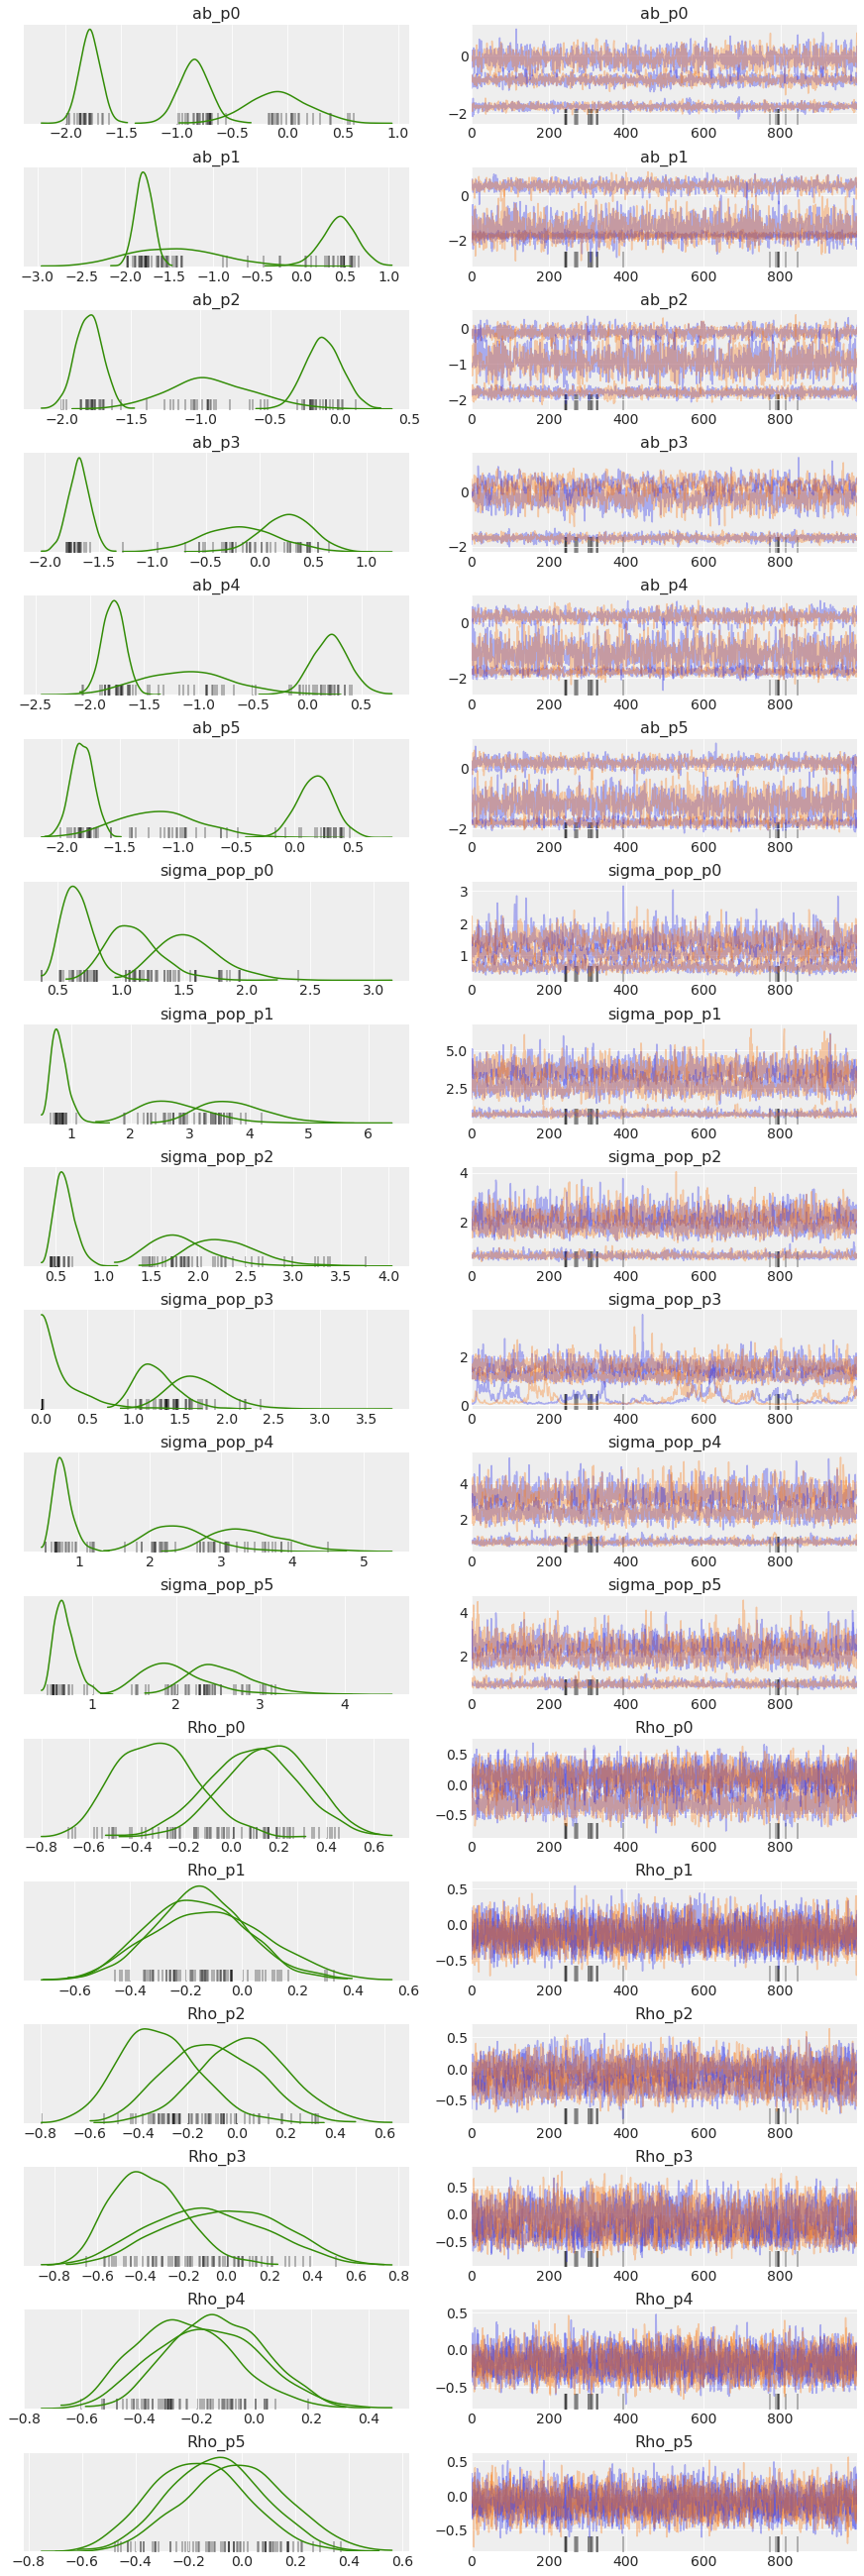

In [11]:
az.plot_trace(
    trace_real,
    var_names=[
        "ab_p0",
        "ab_p1",
        "ab_p2",
        "ab_p3",
        "ab_p4",
        "ab_p5",
        "sigma_pop_p0",
        "sigma_pop_p1",
        "sigma_pop_p2",
        "sigma_pop_p3",
        "sigma_pop_p4",
        "sigma_pop_p5",
        "Rho_p0",
        "Rho_p1",
        "Rho_p2",
        "Rho_p3",
        "Rho_p4",
        "Rho_p5",
    ],
    compact=True,
    combined=True,
)

Everything looks fine. Now let's tackle posterior predictive checks! We'll draw two types of PPC here, starting by what Richard McElreath calls "**counterfactual plots**". These show how predictions change when the one predictor in our model varies, even when this predictor takes unreal values -- hence "counterfactual". 

So, we are going to sample posterior predictive probabilities from the model, with new `unemployment` values. This means we get 4000 samples for each party's probability, in each district, under the new counterfactual conditions. The plots then display the change in probability across values of the predictor of interest and... tadaaaa!

In [11]:
# counterfactuals for a given district:
d_id = np.random.randint(0, Ndistricts)
predictor_seq = np.linspace(-3, 4)
mus_pp = []
for p in range(Nparties - 1):
    vary_eff_pp = []
    for pred in predictor_seq:
        vary_eff_pp.append(
            trace_real[f"ab_district_p{p}"][:, d_id, 0]
            + trace_real[f"ab_district_p{p}"][:, d_id, 1] * pred
        )
    mus_pp.append(vary_eff_pp)
mus_pp = np.asarray(mus_pp)
mus_pp.shape

(6, 50, 2000)

In [12]:
# append last category:
mus_other = np.full(shape=(1, mus_pp.shape[1], mus_pp.shape[2]), fill_value=-2.2)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000)

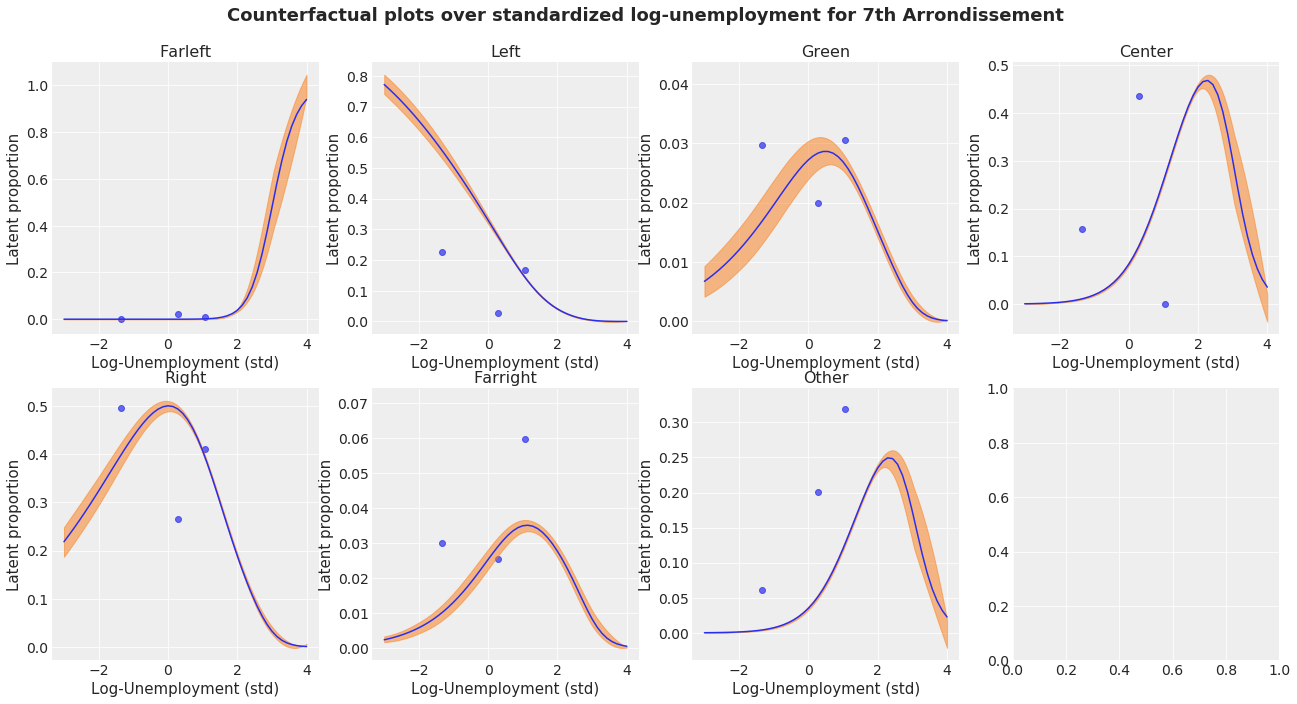

In [13]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            col.scatter(
                d.loc[d.arrondissement == d_id + 1, "log_unemp"],
                d.loc[d.arrondissement == d_id + 1, f"{PARTIES[i]}"]
                / d.loc[d.arrondissement == d_id + 1, "N"],
                alpha=0.7,
            )
            col.plot(predictor_seq, prob_mean[i, :])
            az.plot_hpd(predictor_seq, prob_pp[i, :, :].T, ax=col)
            col.set_xlabel("Log-Unemployment (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Counterfactual plots over standardized log-unemployment for {d_id + 1}th Arrondissement",
    y=0.95,
    size=18,
    weight="bold",
)

In [14]:
# counterfactuals for all districts:
mus_pp = []
for p in range(Nparties - 1):
    vary_eff_pp = []
    for pred in predictor_seq:
        vary_eff_pp.append(
            trace_real[f"ab_district_p{p}"][:, :, 0]
            + trace_real[f"ab_district_p{p}"][:, :, 1] * pred
        )
    mus_pp.append(vary_eff_pp)
mus_pp = np.asarray(mus_pp)
mus_pp.shape

(6, 50, 2000, 20)

In [15]:
# append last category:
mus_other = np.full(
    shape=(1, mus_pp.shape[1], mus_pp.shape[2], mus_pp.shape[3]), fill_value=-2.2
)
mus_pp = np.vstack((mus_pp, mus_other))

# preferences over values of unemp for given district:
prob_pp = softmax(mus_pp, axis=0)
prob_pp.shape

(7, 50, 2000, 20)

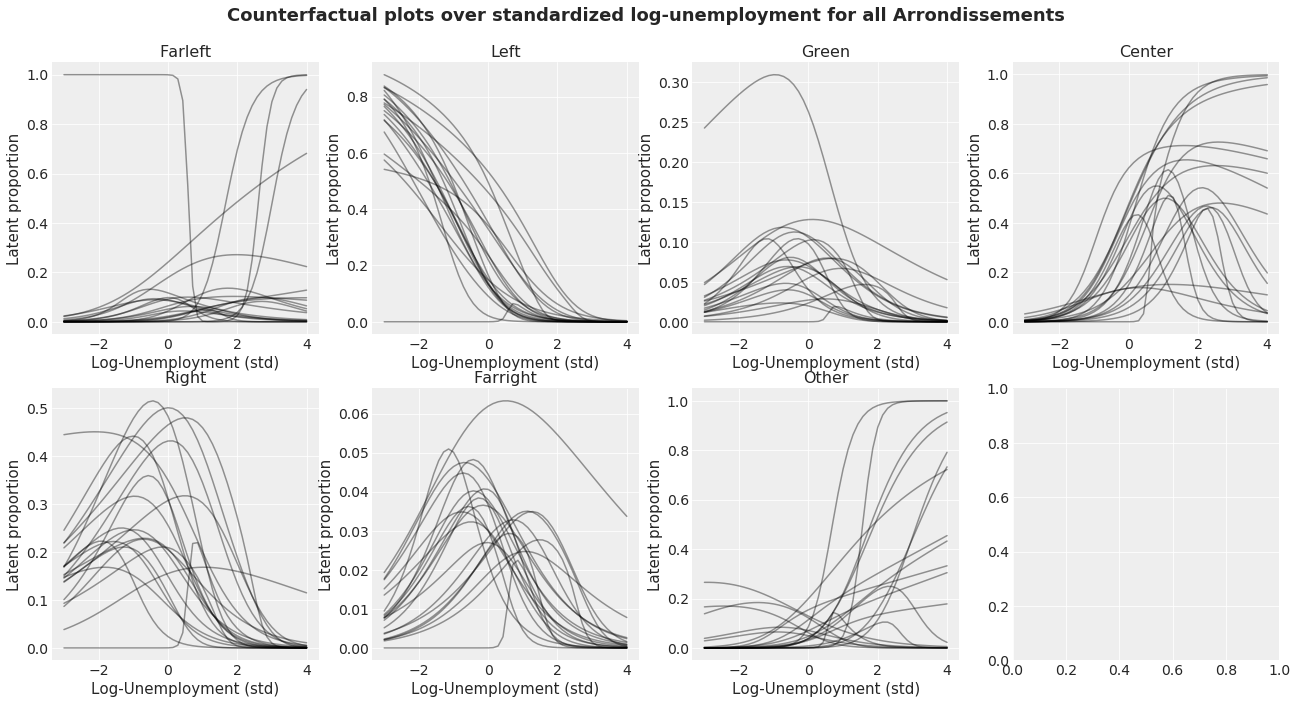

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
prob_mean = prob_pp.mean(2)
i = 0
for line in axes:
    for col in line:
        try:
            for dis in range(Ndistricts):
                col.plot(predictor_seq, prob_mean[i, :, dis], "k", alpha=0.4)
            col.set_xlabel("Log-Unemployment (std)")
            col.set_ylabel("Latent proportion")
            col.set_title(f"{PARTIES[i].title()}")
            i += 1
        except IndexError:
            continue
fig.suptitle(
    "Counterfactual plots over standardized log-unemployment for all Arrondissements",
    y=0.95,
    size=18,
    weight="bold",
)

These plots help us understand the model's implications. As seen in the summary table, the only reliably positive slope is for the centrist party, while the only reliably negative one is for the far left party. This means that when unemployment increases, so does the centrist party's share, on average, while the farl left's decreases. For other parties, the effect of unemployment seems more ambiguous, helping then hurting them when unemployment reaches 0 (its mean value). 

Don't forget however that these effects are contingent on the district we're looking at -- some districts may react more to unemployment than others -- and, as slopes and intercepts are correlated, the variation is multi-dimensional -- yeah, it's a complicated model and the best way to understand it is to plot what it's telling us on the outcome space, as we did here.

Keep in mind though that these predictons are *counterfactual*: they display predictions for sometimes impossible values of the predictor - unrealistically high or low unemployment rates. Also, here we show the raw, observed proportions for each party, but the lines depict the *latent* probabilities -- which we don't get to observe. So, if the fit is not perfect, it's because it's normal. First, the model is trying to infer the latent probabilities from the observed, zero-inflated proportions, which inevitably leads to differences. Second, we should't expect perfect fit in-sample, because the model pools information among intercepts and slopes -- which reduces in-sample fit to improve out-of-sample predictions.

However, it's interesting to compare the model's predictions against raw data. Let's do that, now that we have a better understanding of the posterior distribution. The idea is to plot predictions against observed data, to see if the model correctly approximates the posterior distribution, and where the model fails. That's what the appropriately named "**posterior predictive plots**" do. We'll begin with in-sample predictions (what does the model say about the elections it learned on) and will go on with out-of-sample predictions of the European 2019 elections:

In [17]:
share_est = parties_available * trace_real["lat_p"]
share_est = share_est / np.sum(share_est, axis=2, keepdims=True)
share_mean = share_est.mean(0)

Text(0.5, 0.95, 'Posterior predictions for 2008-05-23 election')

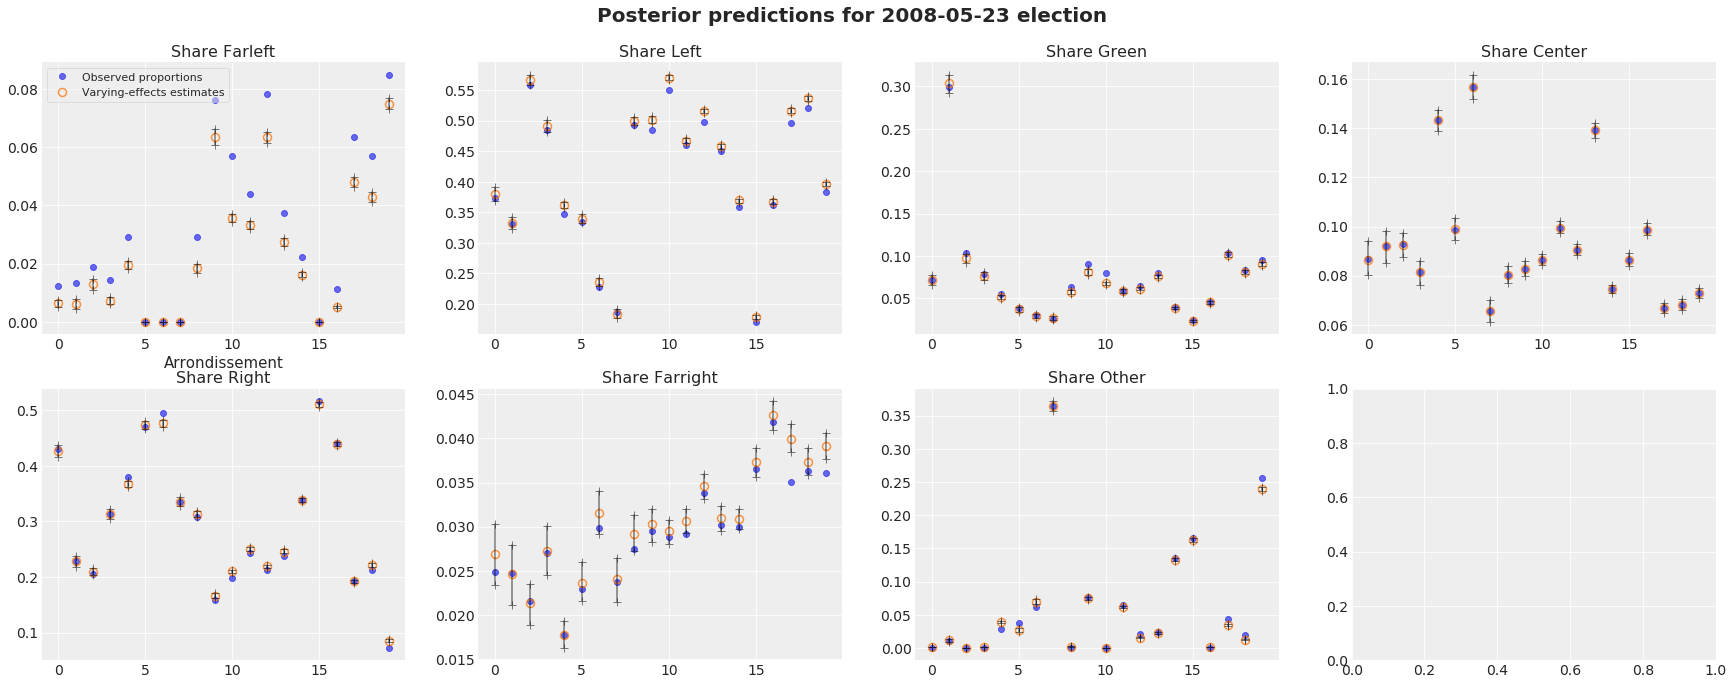

In [20]:
election = "2008-05-23"
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
i = 0
for line in axes:
    for col in line:
        try:
            col.plot(
                np.arange(Ndistricts),
                d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
                "o",
                ms=6,
                alpha=0.7,
                label="Observed proportions",
            )
            col.plot(
                np.arange(Ndistricts),
                share_mean[election_mask, i],
                "o",
                fillstyle="none",
                ms=8,
                markeredgewidth=1.5,
                alpha=0.8,
                label="Varying-effects estimates",
            )
            col.plot(
                [np.arange(Ndistricts), np.arange(Ndistricts)],
                az.hpd(share_est[:, election_mask, i]).T,
                "k-+",
                ms=8,
                alpha=0.5,
            )
            col.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
            col.set_title(f"Share {PARTIES[i].title()}")
            if i == 0:
                col.set_xlabel("Arrondissement")
                col.legend(frameon=True, framealpha=0.5, fontsize=11)
            i += 1
        except IndexError:
            continue
fig.suptitle(
    f"Posterior predictions for {election} election", y=0.95, size=20, weight="bold",
)

Because of shrinkage, we don't expect the posterior to just repeat the data -- the whole point of varying-effects is to trade-off worse fit in-sample for better predictions out-of-sample. Here is however, the model seems to be too far off for most parties, especially for the left and far left parties. Something is influencing these parties' scores that we didn't include in the model yet.

Interestingly, the model is very good at grasping the trend for the centrist party. Remember that center is the only party that has a clear linear relationship with unemployment, so this could be an explanation. In other words, if we want to improve the model's performance, we should find other predictors that inform us better about the other parties -- as unemployment informs us about the centrist party.

And just in case you're doubting, it *is* useful to have unemployment in the model, although only center really benefits from it. If we run the intercept-only model, you'll see that its posterior predictions are even worse than the covariance model.

In [ ]:
# IMMOBILIER: https://basebien.com/PNSPublic/DocPublic/HistoriquedesprixaumappartementsanciensParispararrdt.pdf, https://m2paris.fr/ et http://paris.notaires.fr/fr/carte-des-prix
# http://opendata.apur.org/datasets/recensement-commune-emploi?geometry=1.789%2C48.751%2C2.942%2C48.909

# euro2019
# shrinkage